# Bounding integrals with AutoBound

This notebook shows how AutoBound can be used to compute bounds on the integral of a one-dimensional function.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/autobound/blob/main/autobound/notebooks/bounding_integrals.ipynb)

## Install autobound

In [ ]:
%pip install autobound

## Compute upper and lower bounds on integrals

We first define a helper function that returns the integral of a polynomial, given its coefficients.

In [1]:
from typing import Sequence


def integrate(coefficients: Sequence[float], a: float, b: float) -> float:
  """Integrate a polynomial, given its coefficients."""
  def antiderivative(x):
    return sum(c*(x**(i+1))/(i+1) for i, c in enumerate(coefficients))
  return antiderivative(b) - antiderivative(a)


assert integrate([2.], 0., 3.) == 6
assert integrate([2., 3.], 0., 3.) == 6 + 4.5*3

Using this helper function, we can compute upper and lower bounds on the integral of a function f by first computing polynomial upper and lower bounds on f, then integrating the polynomials.

In [2]:
import autobound.jax as ab
import numpy as np
import jax.numpy as jnp


def integral_bound_v0(f, a, b, degree):
  if degree % 2 != 0:
    # Assume even degree for simplicity.  If the degree is odd, the upper
    # and lower bounds would be piecewise-polynomial with separate pieces
    # for the interals [a, x0] and [x0, b].
    raise NotImplementedError(degree)
  x0 = (a+b)/2
  bounds = ab.taylor_bounds(f, degree)(x0, (a, b))
  lower_bound_coefficients = [float(c[0]) if isinstance(c, tuple) else float(c)
                              for c in bounds.coefficients]
  upper_bound_coefficients = [float(c[1]) if isinstance(c, tuple) else float(c)
                              for c in bounds.coefficients]
  return (integrate(lower_bound_coefficients, a-x0, b-x0),
          integrate(upper_bound_coefficients, a-x0, b-x0))


# If the function is quadratic and we set degree==2 (or higher), the lower and
# upper bounds should match the exact value.
lower, upper = integral_bound_v0(lambda x: x**2, 0., 1., 2)
assert abs(lower - 1/3) < 1e-12
assert abs(upper - 1/3) < 1e-12

As we increase the degree of the polynomial upper and lower bounds, the upper bounds on the integral become tighter.  Let's plot the upper and lower bounds as a function of the polynomial degree.

degree = 0 (lower bound, upper bound) = (-23.5, 30.128305435180664)
degree = 2 (lower bound, upper bound) = (0.009621938069661384, 2.829857190450033)
degree = 4 (lower bound, upper bound) = (1.1261181195576986, 1.3056891282399494)
degree = 6 (lower bound, upper bound) = (1.206216348778634, 1.2129354079564414)
degree = 8 (lower bound, upper bound) = (1.20935602952534, 1.2095172998776276)



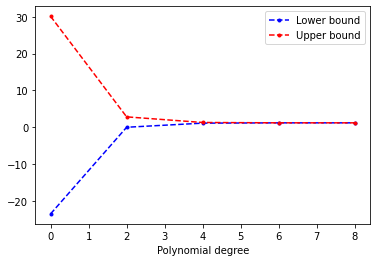

In [3]:
from matplotlib import pyplot

# Define a function f, to be integrated over [a, b].
f = lambda x: 1.5*jnp.exp(3*x) - 25*x**2
a = 0.
b = 1.

# Compute lower and upper bounds using polynomials of various degrees.
degree_to_bounds = {}
for i in range(5):
  degree = 2*i
  degree_to_bounds[degree] = integral_bound_v0(f, a, b, degree)
  print('degree =', degree, '(lower bound, upper bound) =',
        degree_to_bounds[degree])
print()

# Plot the bounds as a function of the polynomial degree.
degrees = sorted(degree_to_bounds.keys())
pyplot.plot(degrees, [degree_to_bounds[d][0] for d in degrees], 'b--',
            label="Lower bound", marker='.')
pyplot.plot(degrees, [degree_to_bounds[d][1] for d in degrees], 'r--',
            label="Upper bound", marker='.')
pyplot.xlabel("Polynomial degree")
pyplot.legend()
pyplot.show()

Another way to get tighter bounds is to subdivide the region of integration into a number of cells, compute separate upper and lower bounds for each cell, and sum them up.

In [4]:
def integral_bound_v1(f, a, b, degree, num_grid_cells):
  sum_lower = 0.
  sum_upper = 0.
  w = (b - a) / num_grid_cells
  for i in range(num_grid_cells):
    a_i = a + w*i
    b_i = a_i + w
    lower, upper = integral_bound_v0(f, a_i, b_i, degree)
    sum_lower += lower
    sum_upper += upper
  return sum_lower, sum_upper


# As with integral_bound_v0, we should get exact bounds for functions that
# are polynomials of degree <= the `degree` parameter.
lower, upper = integral_bound_v1(lambda x: x**2, 0., 1., 2, 1)
assert abs(lower - 1/3) < 1e-12
assert abs(upper - 1/3) < 1e-12

Let's look at how the lower and upper bounds change as we vary the number of grid cells.

#(grid cells) = 1 (lower bound, upper bound) = (0.009621938069661384, 2.829857190450033)
#(grid cells) = 2 (lower bound, upper bound) = (1.0153448383013406, 1.4349525968233747)
#(grid cells) = 4 (lower bound, upper bound) = (1.1829608430465064, 1.2379716920355956)
#(grid cells) = 8 (lower bound, upper bound) = (1.2060198349257312, 1.212980562200149)
#(grid cells) = 16 (lower bound, upper bound) = (1.2090029227741375, 1.2098756911000237)



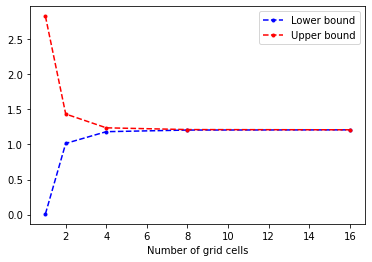

In [5]:
# Define a function f, to be integrated over [a, b].
f = lambda x: 1.5*jnp.exp(3*x) - 25*x**2
a = 0.
b = 1.

num_cells_to_bounds = {}
degree = 2
for i in range(5):
  num_cells = 2**i
  num_cells_to_bounds[num_cells] = integral_bound_v1(f, a, b, degree, num_cells)
  print('#(grid cells) =', num_cells, '(lower bound, upper bound) =',
        num_cells_to_bounds[num_cells])
print()


# Plot the bounds as a function of the number of grid cells.
ns = sorted(num_cells_to_bounds.keys())
pyplot.plot(ns, [num_cells_to_bounds[n][0] for n in ns], 'b--',
            label="Lower bound", marker='.')
pyplot.plot(ns, [num_cells_to_bounds[n][1] for n in ns], 'r--',
            label="Upper bound", marker='.')
pyplot.xlabel("Number of grid cells")
pyplot.legend()
pyplot.show()

More sophisticated approaches are possible!  In particular, instead of using a uniform grid, we could adaptively refine the grid by subdividing cells where the gap between the upper and lower bounds is largest.